# Plotting the metric curves

This file contains functions for plotting the metric curves in the paper.

In [1]:
%matplotlib inline
import os
import errno
import warnings
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Deal with the bold roman font bug, see
#   https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 16.0
plt.rcParams['savefig.dpi'] = 120

In [3]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def color_variant(hex_color, brightness_offset=1):
    """Takes a hex color code and produces a lighter or darker variant."""
    if len(hex_color) != 7:
        raise ValueError("Unrecognizable color code. Should be like #5F4B8B.")
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    rgb_int = [min([255, max([0, i])]) for i in rgb_int] 
    return "#" + "".join(['{:0>2}'.format(hex(i)[2:]) for i in rgb_int])

In [4]:
traing_data_eval_path = './data/training_data/lastfm_alternative_8b_phrase.npy'
data_dir = './data/eval_training_progress/'
result_dir = './figs/'
extension = 'png' # 'pdf', 'ps', 'eps', 'svg'

In [5]:
make_sure_path_exists(result_dir)
make_sure_path_exists(os.path.join(result_dir, 'two-stage'))
make_sure_path_exists(os.path.join(result_dir, 'end2end'))
make_sure_path_exists(os.path.join(result_dir, 'ablated'))

In [6]:
track_names = (
    'Drums', 'Piano', 'Guitar', 'Bass', 'Ensemble', 'Reed', 'Synth Lead',
    'Synth Pad'
)
metric_names = (
    'empty bar rate', '# of pitch used', 'qualified note rate', 'polyphonicity',
    'note in scale', 'drum in pattern rate', '# of chroma used'
)
metric_file_names = (
    'empty_bar_rate', 'num_pitch_used', 'qualified_note_rate', 'polyphonicity',
    'note_in_scale', 'drum_in_pattern', 'num_chroma_used'
)

## Load merged evaluation files

In [7]:
def load_metrics(filename, start_step=0):
    """Load a merged metric file and return it as a dictionary."""
    results = {}
    with np.load(os.path.join(data_dir, filename)) as loaded:
        results['steps'] = loaded['steps'] + start_step
        results['score_matrix_means'] = loaded['score_matrix_means']
        results['score_pair_matrix_means'] = loaded['score_pair_matrix_means']
    return results

def update_metrics(filename, metric_dict, start_step=0):
    """Update a metric array dictionary with a merged metric file."""
    with np.load(os.path.join(data_dir, filename)) as loaded:
        mask = (metric_dict['steps'] < loaded['steps'].min() + start_step)
        metric_dict['steps'] = np.concatenate(
            (metric_dict['steps'][mask], loaded['steps'] + start_step)
        )
        metric_dict['score_matrix_means'] = np.concatenate(
            (metric_dict['score_matrix_means'][mask],
             loaded['score_matrix_means'])
        )
        metric_dict['score_pair_matrix_means'] = np.concatenate(
            (metric_dict['score_pair_matrix_means'][mask],
             loaded['score_pair_matrix_means'])
        )

### Training data statistics

In [8]:
train = np.load(traing_data_eval_path)

### Pretrained models

In [9]:
pretrained_proposed = load_metrics("lastfm_alternative_pretrain_g_proposed_"
                                   "d_proposed.npz")
pretrained_ablated = load_metrics("lastfm_alternative_pretrain_g_proposed_"
                                  "d_ablated.npz")
pretrained_baseline = load_metrics("lastfm_alternative_pretrain_g_proposed_"
                                   "d_baseline.npz")

### Two-stage models (proposed)

In [10]:
second_stage_step = 55470 # steps when second-stage training start
proposed_round = load_metrics("lastfm_alternative_train_g_proposed_d_"
                              "proposed_r_proposed_round.npz",
                              second_stage_step)
proposed_bernoulli = load_metrics("lastfm_alternative_train_g_proposed_d_"
                                  "proposed_r_proposed_bernoulli.npz",
                                  second_stage_step)

### Two-stage models (joint)

In [11]:
joint_round = load_metrics("lastfm_alternative_train_joint_g_proposed_d_"
                           "proposed_r_proposed_round.npz", second_stage_step)
joint_bernoulli = load_metrics("lastfm_alternative_train_joint_g_proposed_d_"
                               "proposed_r_proposed_bernoulli.npz",
                               second_stage_step)

### End-to-end models

In [12]:
end2end_round = load_metrics("lastfm_alternative_end2end_g_proposed_small_d_"
                             "proposed_r_proposed_round.npz")
end2end_bernoulli = load_metrics("lastfm_alternative_end2end_g_proposed_small_"
                                 "d_proposed_r_proposed_bernoulli.npz")

## Comparison of Training Strategies

We compare the proposed training strategy with two alternative ones.

- **proposed**: pretrain G and D in the first stage, and then train R and D (while G is fixed) in the second stage.
- **joint**: pretrain G and D in the first stage, and then train G and R (like viewing R as part of G) jointly with D in the second stage.
- **end-to-end**: train G, R and D jointly in one stage.

### Comparison of Two-stage Training Strategies

In [13]:
def plot_metric(x, m, smooth, k=None, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        to_plot = np.nanmean(x['score_matrix_means'][:, m], 1)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], to_plot, '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            smoothed = movingaverage(to_plot, k)
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        elif smooth == 'med':
            smoothed = scipy.signal.medfilt(to_plot, k)[h:-h]
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        if smooth is not None and smooth != 'none':
            plt.plot(x['steps'], to_plot, '-', linewidth=.3, color='0.7',
                     zorder=0)

def plot_tonal_distance(x, m, smooth, k=None, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        to_plot = x['score_pair_matrix_means'][:, 0]
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], to_plot, '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            smoothed = movingaverage(to_plot, k)
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        elif smooth == 'med':
            smoothed = scipy.signal.medfilt(to_plot, k)[h:-h]
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        if smooth is not None and smooth != 'none':
            plt.plot(x['steps'], to_plot, '-', linewidth=.3, color='0.7',
                     zorder=0)

In [14]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_proposed, m, smooth, k, label='pretrain',
                linewidth=.8)
    plot_metric(proposed_round, m, smooth, k, label='proposed (+DBNs)',
                linewidth=.8)
    plot_metric(proposed_bernoulli, m, smooth, k, label='proposed (+SBNs)',
                linewidth=.8)
    plot_metric(joint_round, m, smooth, k, label='joint (+DBNs)', linewidth=.8)
    plot_metric(joint_bernoulli, m, smooth, k, label='joint (+SBNs)',
                linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'two-stage',
                                'two-stage_{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

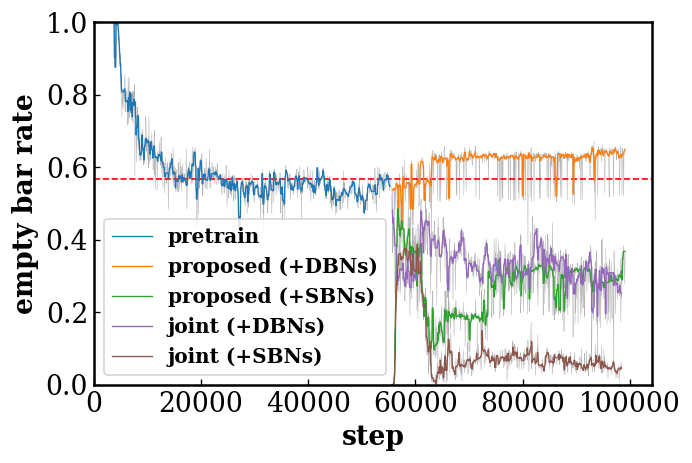

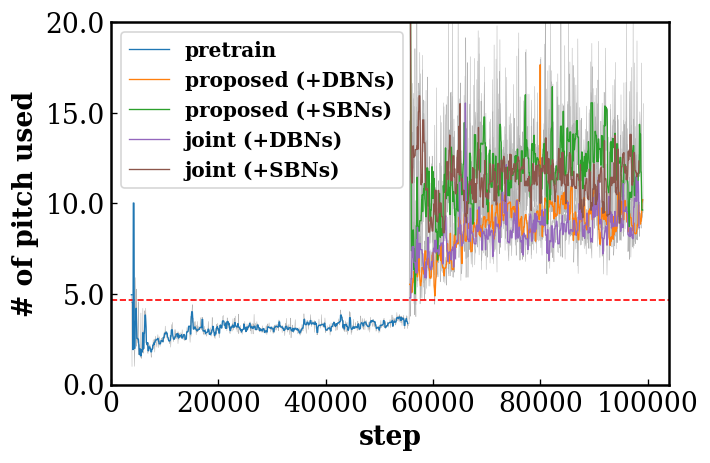

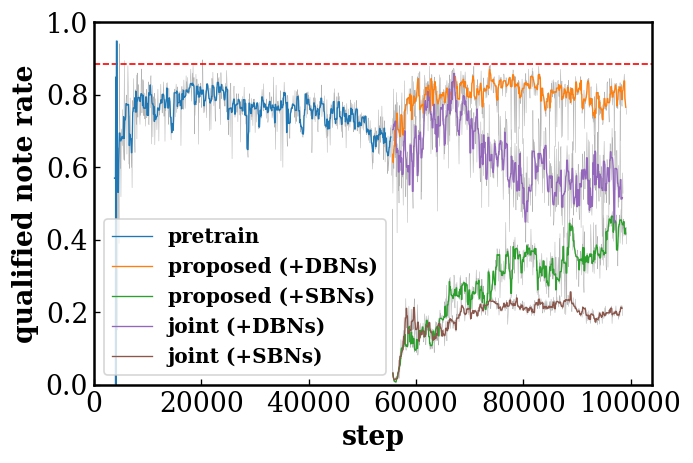

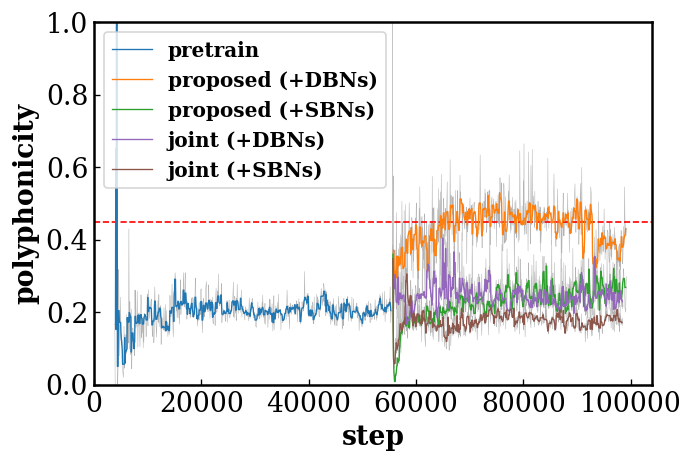

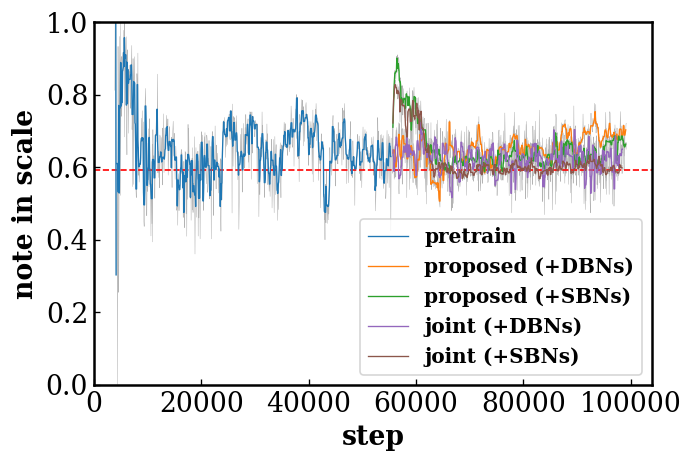

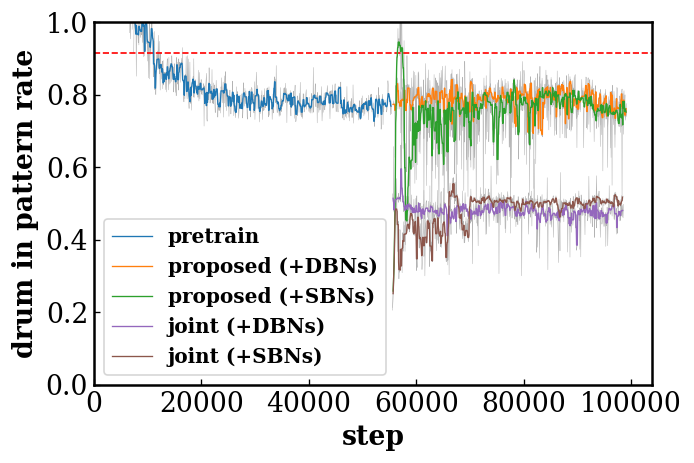

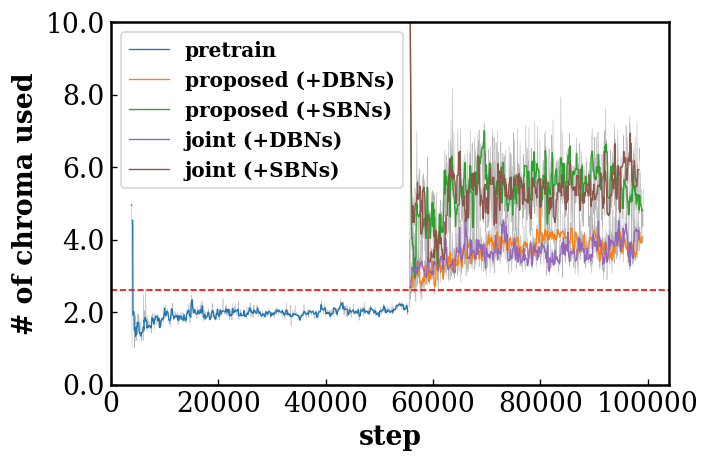

In [15]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

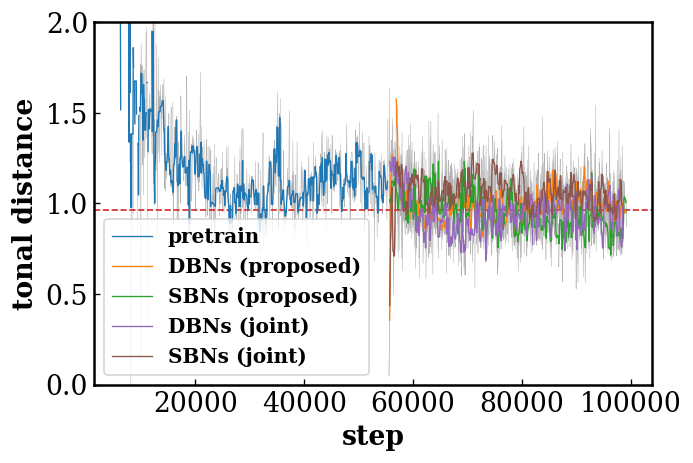

In [16]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

plot_tonal_distance(pretrained_proposed, m, smooth, k, label='pretrain',
                    linewidth=.8)
plot_tonal_distance(proposed_bernoulli, m, smooth, k, label='DBNs (proposed)',
                    linewidth=.8)
plot_tonal_distance(proposed_round, m, smooth, k, label='SBNs (proposed)',
                    linewidth=.8)
plot_tonal_distance(joint_round, m, smooth, k, label='DBNs (joint)',
                    linewidth=.8)
plot_tonal_distance(joint_bernoulli, m, smooth, k, label='SBNs (joint)',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'two-stage',
                        'two-stage_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')

### Comparison of End-to-end Training Strategies

In [17]:
k = 3
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs_end2end = [1, 1, 1, 1, 4, 4, 1]
ylims_end2end = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 8)]

def plot_metrics(m, save=False, close=False):
    plot_metric(end2end_round, m, smooth, k, label='end-to-end (+DBNs)',
                linewidth=.8)
    plot_metric(end2end_bernoulli, m, smooth, k, label='end-to-end (+SBNs)',
                linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims_end2end[m][0], ylims_end2end[m][1])
    plt.legend(loc=locs_end2end[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')

    if save:
        filepath = os.path.join(result_dir, 'end2end',
                                'end2end_{}.{}'.format(metric_file_names[m],
                                                       extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

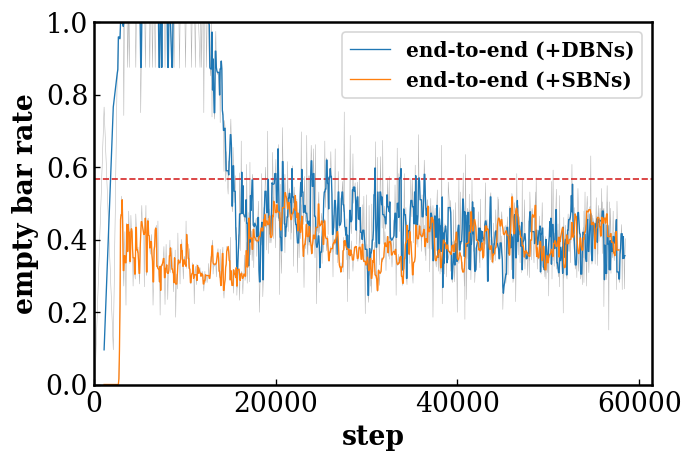

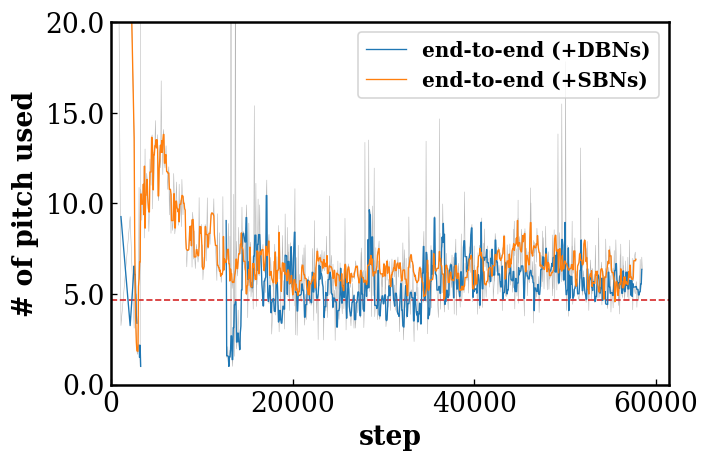

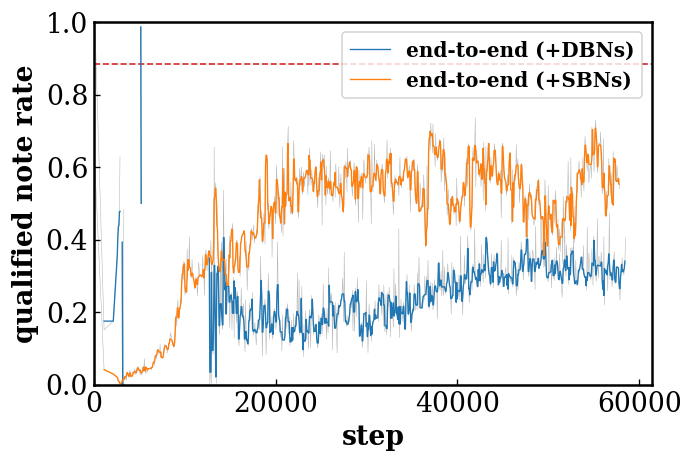

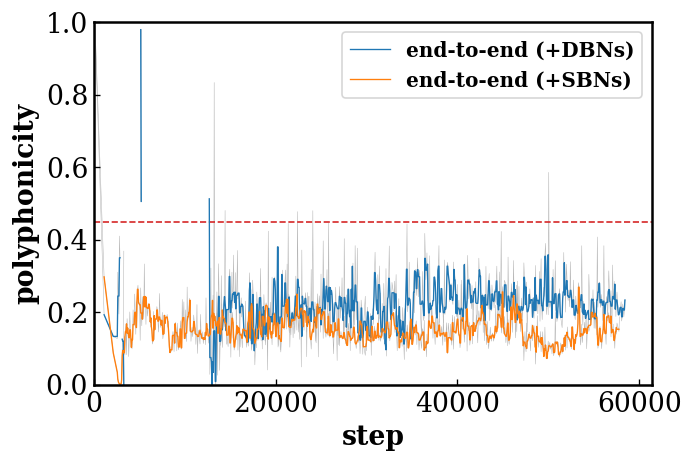

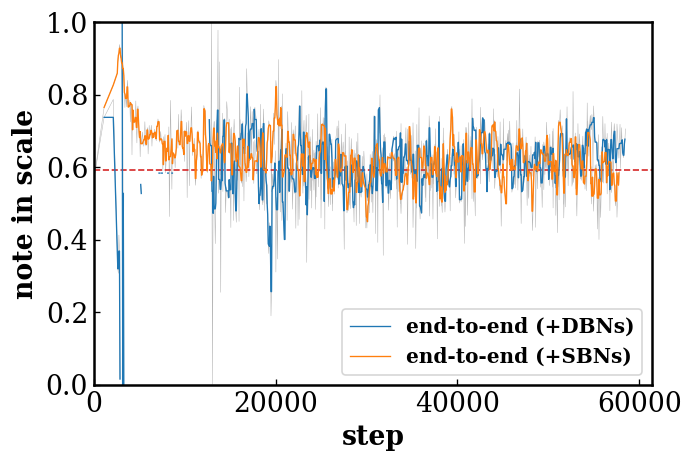

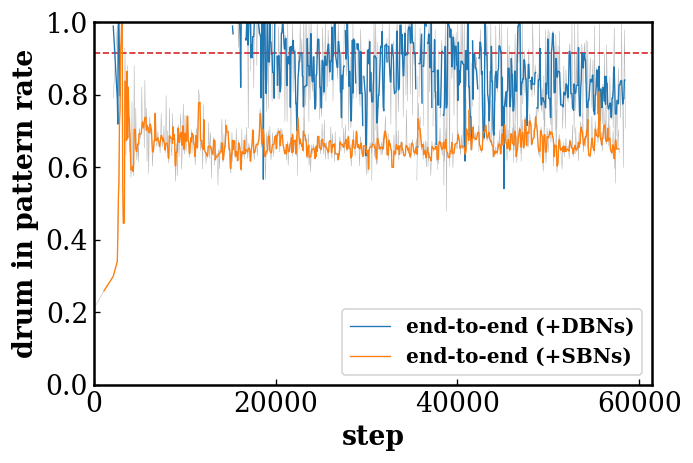

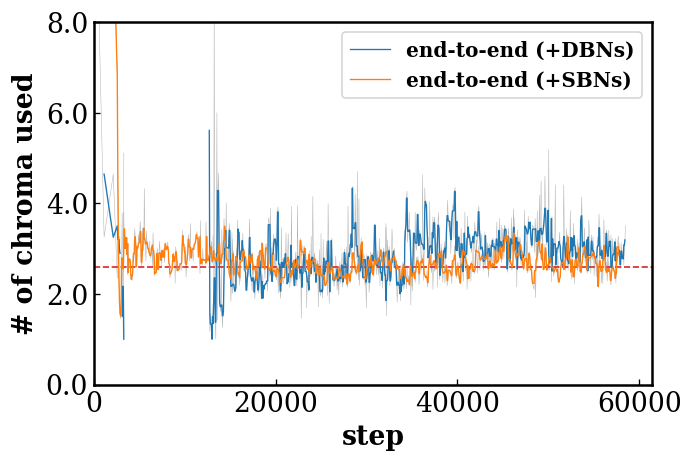

In [18]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

## Effects of the Shared/private and Multi-stream Design of the Discriminator

We compare the proposed model with its ablated version and a baseline model.

- **ablated**: remove the onset/offset and chroma streams.
- **baseline**: use only a shared discriminator without the shared/private design.

In [19]:
k = 5
h = (k - 1)//2
m = 2
smooth = 'med' # 'avg', med', None

locs_ablated = [1, 1, 1, 1, 4, 4, 1]
ylims_ablated = [(0, 1), (0, 11), (0, 1), (0, 1), (0, 1), (.5, 1), (0, 8)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_proposed, m, smooth, k, label='proposed',
                linewidth=.8)
    plot_metric(pretrained_ablated, m, smooth, k,  label='ablated',
                linewidth=.8)
    plot_metric(pretrained_baseline, m, smooth, k,  label='baseline',
                linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.ylim(ylims_ablated[m][0], ylims_ablated[m][1])
    plt.legend(loc=locs_ablated[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')

    if save:
        filepath = os.path.join(result_dir, 'ablated',
                                'ablated_{}.{}'.format(metric_file_names[m],
                                                       extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

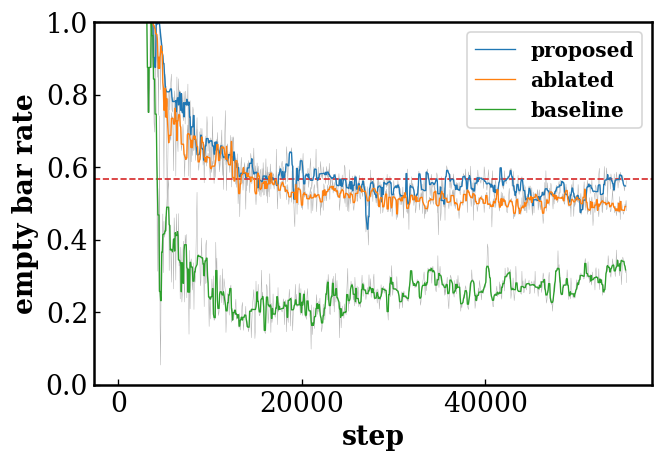

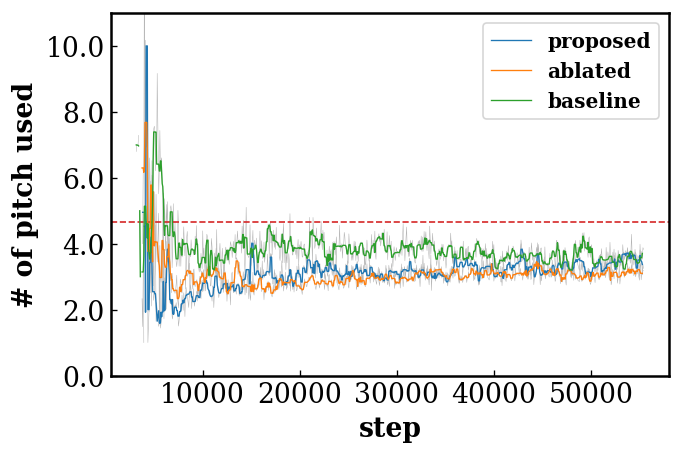

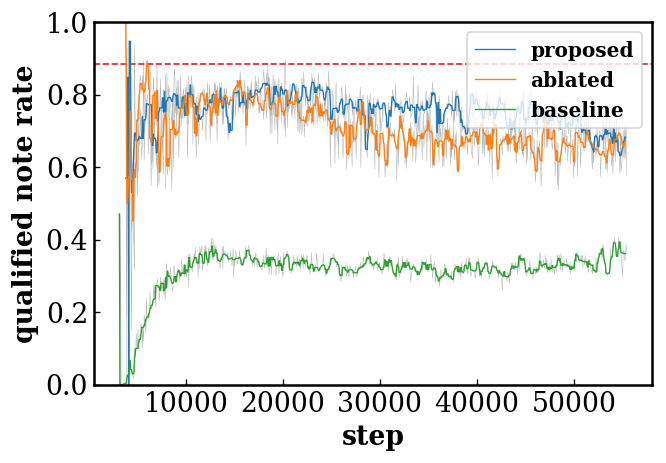

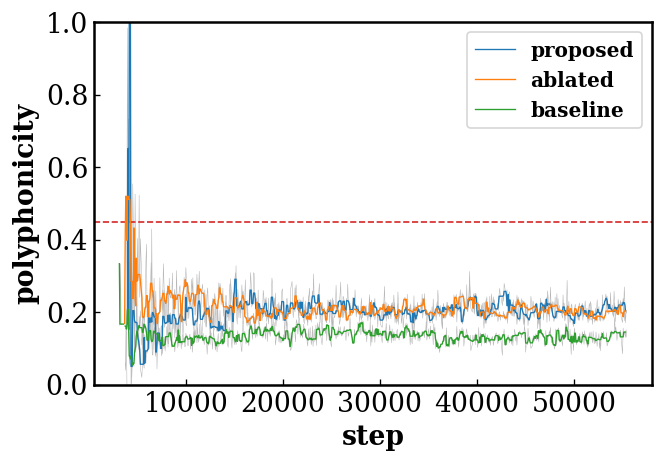

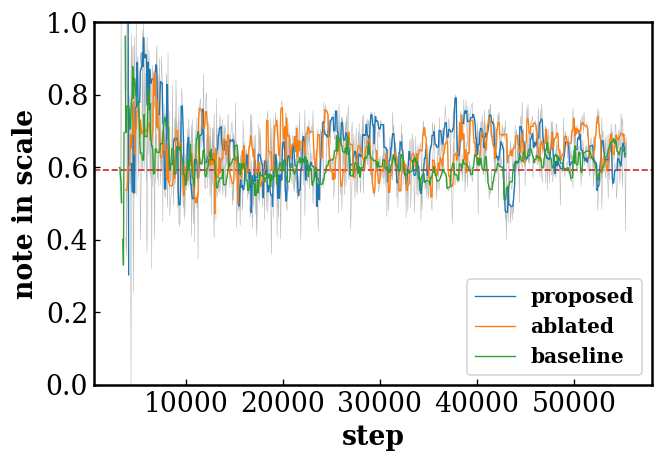

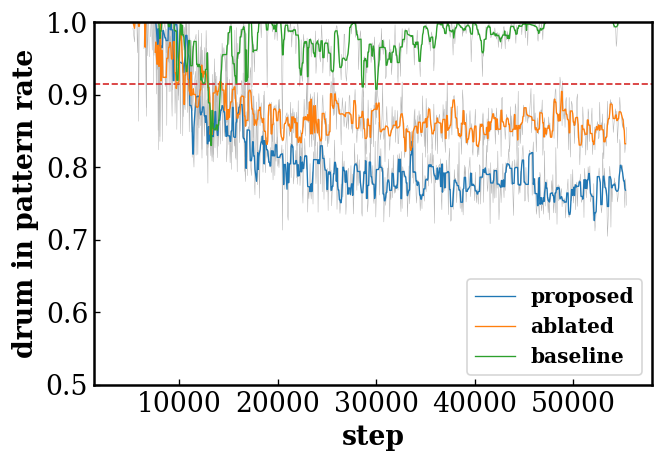

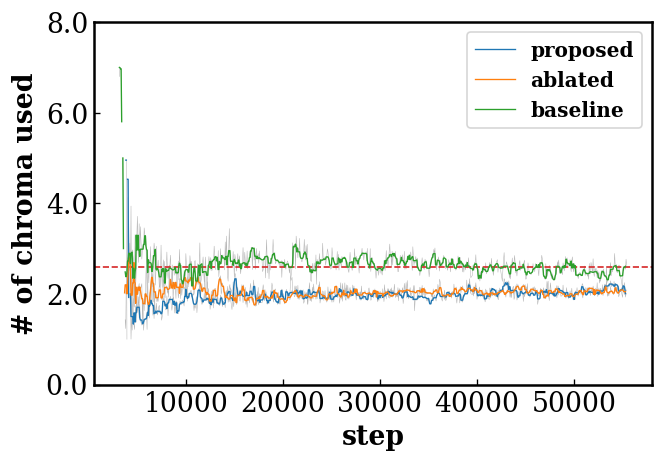

In [20]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

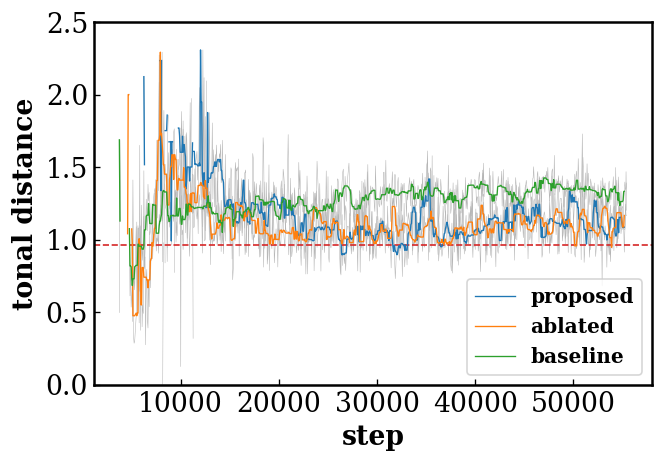

In [21]:
k = 9
h = (k-1)//2
m = 0
smooth = 'med' # 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

plot_tonal_distance(pretrained_proposed, m, smooth, k, label='proposed',
                    linewidth=.8)
plot_tonal_distance(pretrained_ablated, m, smooth, k, label='ablated',
                    linewidth=.8)
plot_tonal_distance(pretrained_baseline, m, smooth, k, label='baseline',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0.0, 2.5)
plt.legend(loc=4, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'ablated',
                        'ablated_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')